In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from matplotlib.colors import ListedColormap

sns.set_style('white')

plt.rc('font', family='sans-serif')
plt.rc('font', serif='Arial')
plt.rc('text', usetex='false')

try:
    plt.style.use('../custom.mplstyle')
except IOError:
    plt.rc('font', size=10)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=12, titlesize=12)
    plt.rc('legend', fontsize=8)

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

In [3]:
def get_pvals(df, c, m):
    values = df.loc[c]
    r = m.loc[c]
    values = pd.concat([values, pd.Series([r], index=['real'])])
    zscores = (values - values.median())/values.mad()
    pvals = stats.norm.sf(abs(zscores))*2
    return multipletests(pvals, method='fdr_bh')[1][-1]

In [4]:
m = pd.read_table('../sickness/123456/auc_weighted_score.2.txt', header=None)
m.columns = ['condition', 'sick', 'strains', 'stat', 'threshold', 'x', 'y', 'kind']
m.set_index('condition', inplace=True)
pr = m[m['kind'] == 'prec'].groupby('condition').mean()['stat'].dropna()

In [5]:
p = (m['sick'] / m['strains']).groupby('condition').mean()

In [6]:
m1 = pd.read_table('../mutations/b1_5_prec.txt',
                   header=None)
m1.columns = ['round1', 'round2', 'condition', 'stat']
m1.set_index('condition', inplace=True)
m1 = m1['stat']

In [7]:
m2 = pd.read_table('../mutations/b2_5_prec.txt',
                   header=None)
m2.columns = ['round1', 'round2', 'condition', 'stat']
m2.set_index('condition', inplace=True)
m2 = m2['stat']

In [8]:
m3 = pd.read_table('../mutations/b3_5_prec.txt',
                   header=None)
m3.columns = ['round', 'condition', 'stat']
m3.set_index('condition', inplace=True)
m3 = m3['stat']

/home/mgalactus/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


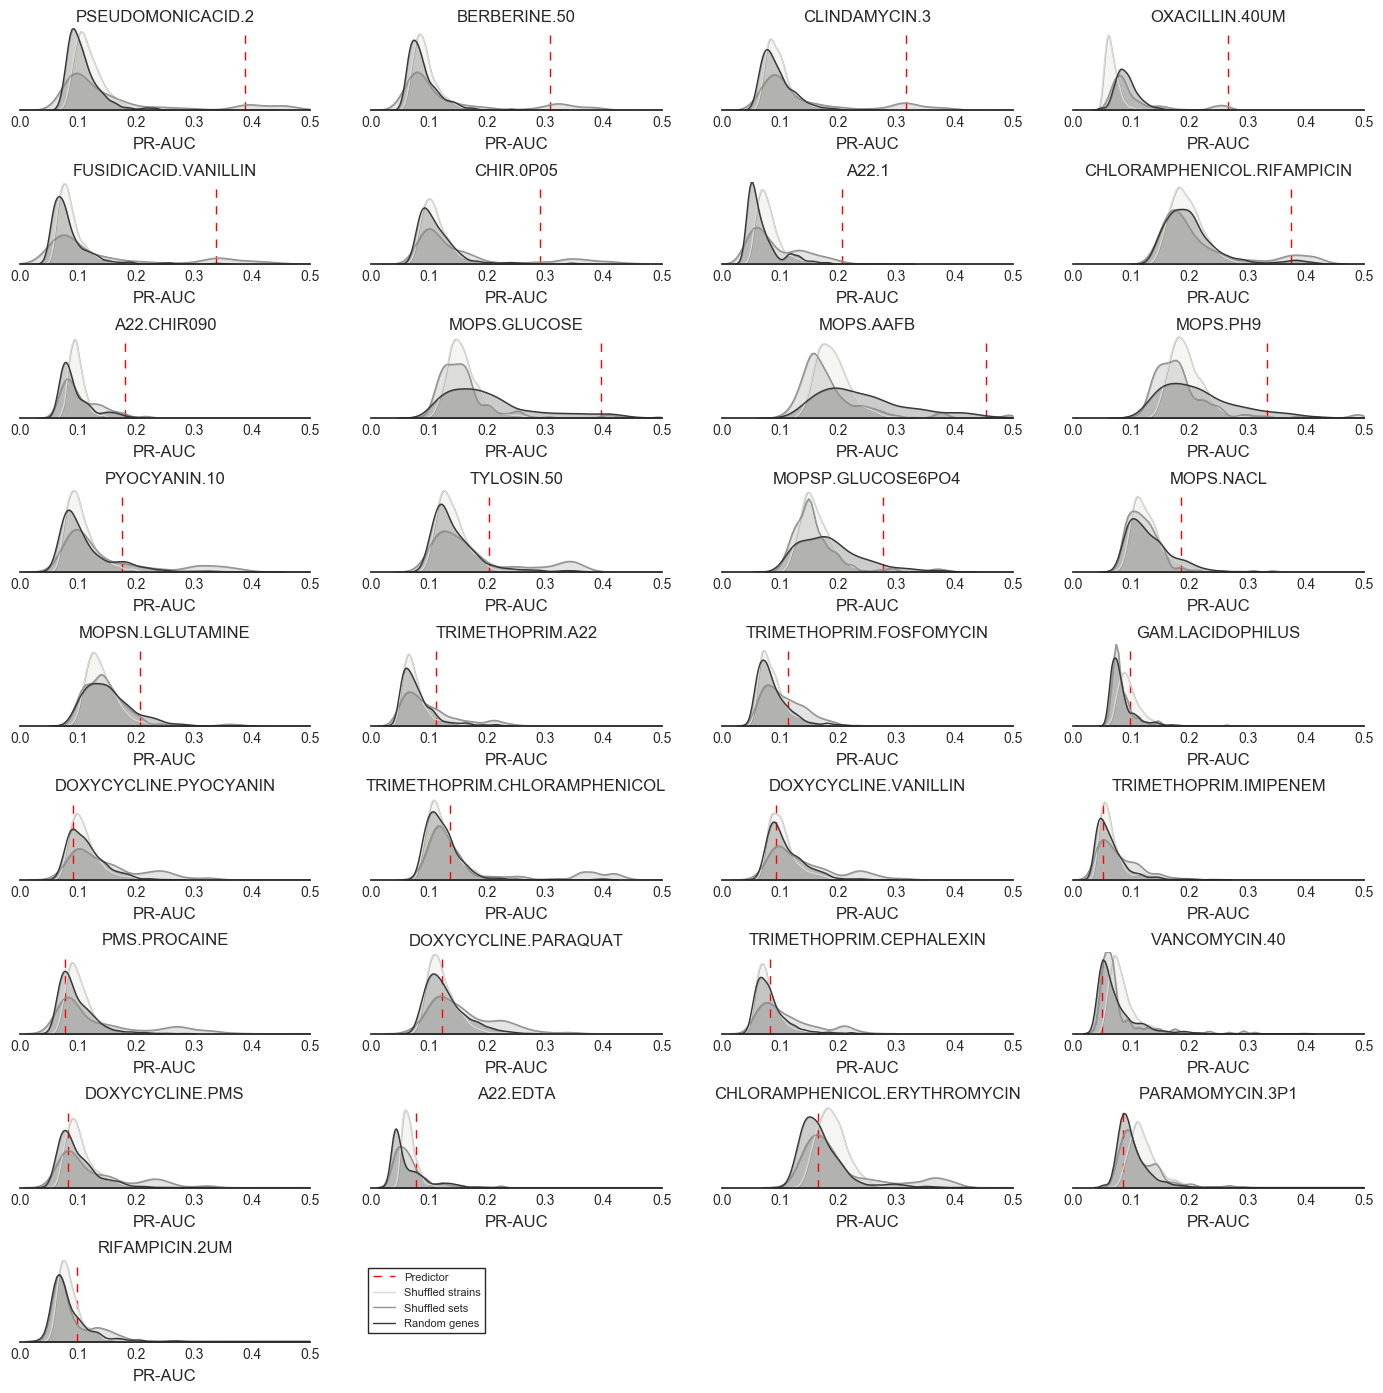

In [9]:
conds = set(pr.loc[p[p >= 0.05].index].index
           ).intersection(m1.index
           ).intersection(m2.index
           ).intersection(m3.index)

pp = pd.Series({c: get_pvals(m3, c, pr) for c in conds})

conds = list(pp.loc[conds].sort_values().index)

plt.figure(figsize=(14, 14))

for i, c in enumerate(conds):
    plt.subplot(9, 4, i+1)
    
    if i+1 == len(conds):
        label1 = 'Shuffled strains'
        label2 = 'Shuffled sets'
        label3 = 'Random genes'
        pred = 'Predictor'
    else:
        label1 = '_'
        label2 = '_'
        label3 = '_'
        pred = '_'
    
    plt.axvline(pr.loc[c],
                linestyle='dashed',
                color='r',
                label=pred)
    
    sns.kdeplot(m1.loc[c],
                color=sns.xkcd_rgb['light grey'],
                shade=True,
                label=label1)
    sns.kdeplot(m2.loc[c],
                color=sns.xkcd_rgb['grey'],
                shade=True,
                label=label2)
    sns.kdeplot(m3.loc[c],
                color=sns.xkcd_rgb['dark grey'],
                shade=True,
                label=label3)
    
    plt.xlabel('PR-AUC')
    plt.xlim(0, 0.5)
    
    plt.title(c)
    
    if i+1 == len(conds):
        plt.legend(bbox_to_anchor=(1.4, 0.5),
                   loc='center',
                   frameon=True)
    
    plt.yticks([])

sns.despine(left=True)
    
plt.tight_layout()

plt.savefig('../figures/supplementary/sfig6.svg',
            dpi=150)